# Introductions

In [1]:
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import scvelo as scv
from tqdm import tqdm

import statsmodels.formula.api as sm
from scipy.stats import poisson

In [2]:
from multiprocessing import Pool

def get_s(data):
    gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
    X = data[:,gene_mask]
    n,p = X.shape
    X_cov = np.cov(X,rowvar=False)
    X_mean = np.mean(X,axis=0)
    X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
    s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
    return s

def bootstrap_s(X,B=10,cores=10):
    n,p = X.shape
    Input_args = []
    for b in range(B):
        sample_idx = np.random.choice(n,n,replace=True)
        sample = X[sample_idx]
        Input_args.append(sample)
            
    with Pool(cores) as pool:      
        s = pool.map(get_s, Input_args, chunksize=1)

    return s

In [3]:
def CCC(y_pred, y_true):
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    
    return numerator / denominator

In [4]:
def select_genes(U,S,gene_names,mean_min=0.1,var_min=1):
    gene_mask = (np.mean(S,axis=0)>0) & (np.mean(U,axis=0)>0) & (np.var(S,axis=0)>0) & (np.var(U,axis=0)>0)
    s = S[:,gene_mask]
    u = U[:,gene_mask]
    gene_names = gene_names[gene_mask]
    cov = np.cov(u,s,rowvar=False)
    s_mean = np.mean(s,axis=0)
    u_mean = np.mean(u,axis=0)
    X_mean = np.append(u_mean,s_mean)
    p = s.shape[1]
    rho = cov/X_mean[:,None]/X_mean[None,:]
    rho_s = rho[p:,p:]
    rho_u = rho[:p,:p]
    rho_us = rho[:p,p:]
    s = (np.sum(rho_us)-np.sum(np.diag(rho_us)))/(p-1)/p
    genes_mask = (s_mean>mean_min) & (u_mean>mean_min) & (np.abs(np.diag(rho_us)-s)>var_min)
    return gene_names[genes_mask]

# 10xv1

In [5]:
#!wget -P ./data https://cf.10xgenomics.com/samples/cell-exp/1.1.0/ercc/ercc_raw_gene_bc_matrices.tar.gz
#!tar -xvf  ./data/ercc_raw_gene_bc_matrices.tar.gz --directory ./data
#!mv ./data/matrices_mex/ ./data/ERCC_10xv1/
#!mv ./data/ERCC_10xv1/ercc92 ./data/ERCC_10xv1/raw

In [6]:
#!wget -P ./data https://cf.10xgenomics.com/samples/cell-exp/1.1.0/ercc/ercc_filtered_gene_bc_matrices.tar.gz
#!tar -xvf  ./data/ercc_filtered_gene_bc_matrices.tar.gz --directory ./data
#!mv ./data/filtered_matrices_mex/ercc92/ ./data/ERCC_10xv1/filtered/
#!rm -r ./data/filtered_matrices_mex

In [7]:
datadir = './data/ERCC_10xv1/filtered/'

In [8]:
ercc = sio.mmread(datadir+'matrix.mtx')
ercc.shape

(92, 1015)

In [9]:
genes = pd.read_csv(datadir+'genes.tsv',sep='\t',header=None)
genes.head()

,0,1
0,ERCC-00002,ERCC-00002
1,ERCC-00003,ERCC-00003
2,ERCC-00004,ERCC-00004
3,ERCC-00009,ERCC-00009
4,ERCC-00012,ERCC-00012


In [10]:
barcodes = pd.read_csv(datadir+'barcodes.tsv',sep='\t',header=None)
barcodes.head()

,0
0,AAACCGTGAAGCCT-1
1,AAACGCACTGCTGA-1
2,AAACTTGACCGAAT-1
3,AAAGACGAGGAAGC-1
4,AAAGACGATCCGAA-1


In [11]:
alldata = ercc.toarray().T
alldata.shape

(1015, 92)

In [35]:
data = alldata[alldata.sum(1)>0]
data.shape

(1015, 92)

In [13]:
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.06308284067958143


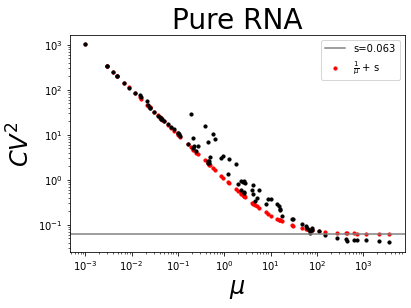

In [14]:
matplotlib.rc('font', size=20)
eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='gray',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=10)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("Pure RNA",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend()

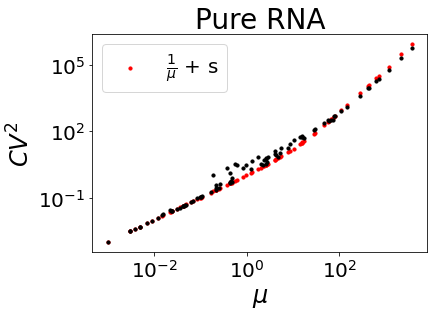

In [15]:
matplotlib.rc('font', size=20)
eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.scatter(X_bar, a*X_bar + s*X_bar**2,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var,c='k',alpha=1, s=10)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("Pure RNA",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend()

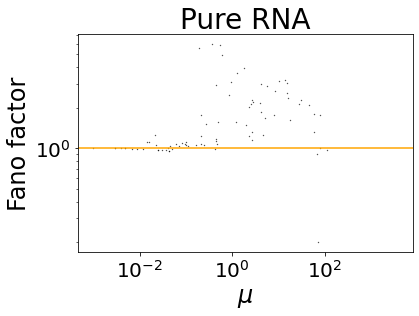

In [17]:
matplotlib.rc('font', size=20)
eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=a, c='orange',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, X_var/X_bar-s*X_bar,c='k',alpha=1, s=0.1)


plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel('Fano factor',fontsize=24)
plt.title("Pure RNA",fontsize=28)
plt.xscale('log')
plt.yscale('log')
#plt.legend();

## droplets variance

In [18]:
data.sum(1).max()

16579.0

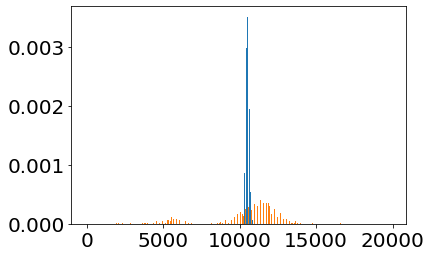

In [19]:
plt.hist([np.random.poisson(data.sum(1).mean(),size=len(data)),data.sum(1)],bins=np.arange(0,20000,100),density=True);

In [152]:
import matplotlib.pyplot as plt
from math import factorial, exp, log
from scipy import integrate, special
from tqdm import tqdm

def f_func(x,z):
    I=len(z)
    J=len(x)
    z=np.reshape(z,(I,1))
    x=np.reshape(x,(1,J))
    Z=np.repeat(z,J,axis=1)
    X=np.repeat(x,I,axis=0)    
    return np.exp(np.log(Z+10**(-10))*X-z-special.gammaln(x+1))

x = data.sum(1)

# parameters
ite_num=10
z_range=20000  

# initialization
n=len(x)
dz=1
z=np.arange(0,z_range+dz,dz) # here use z to denote the discretized t
pi=np.ones_like(z)/z_range
z=np.reshape(z,(len(z),1))


unique, counts = np.unique(x, return_counts=True)
f=f_func(unique,z)
L=np.zeros([ite_num,len(unique)])

# iteration
for i in tqdm(range(ite_num)):  
    f_int=integrate.trapz(f*pi[:,None],z,axis=0) 
    pi=pi*np.sum(counts[None,:]*f/f_int,axis=1)/n
    L[i,:]=f_int

100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Text(0.5, 1.0, 'total counts distribution')

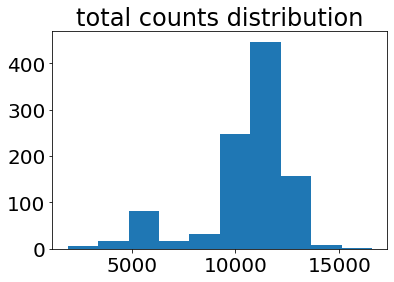

In [153]:
plt.hist(x)
plt.title('total counts distribution')

In [154]:
np.var(x)/x.mean()**2

0.042550781825023226

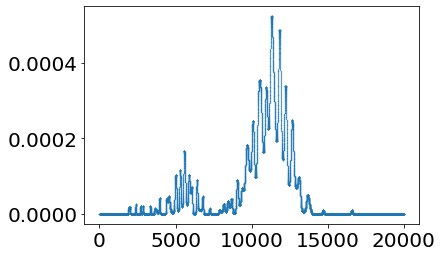

In [155]:
plt.scatter(z,pi,s=0.1);

Text(0.5, 1.0, 'read depth distribution')

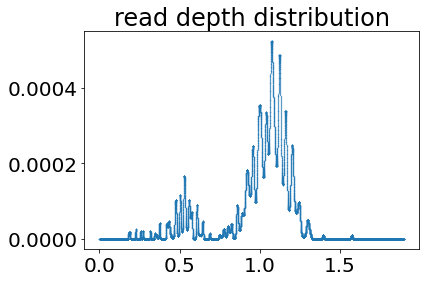

In [156]:
plt.scatter(z/x.mean(),pi,s=0.1);
plt.title('read depth distribution')

In [157]:
m1 = (z[:,0]*pi).sum()
m2 = ((z[:,0]-m1)**2*pi).sum()
m3 = ((z[:,0]-m1)**3*pi).sum()
m4 = ((z[:,0]-m1)**4*pi).sum()
m5 = ((z[:,0]-m1)**5*pi).sum()
m6 = ((z[:,0]-m1)**6*pi).sum()

In [158]:
m2/m1**2

0.042462729054590635

In [104]:
skewness = m3/(m2**1.5)
skewness

-1.5365570285228871

**Less skewer than lognormal and Gamma distribution, but more overdispersed than Normal**

In [75]:
expsigma2 = m2/m1**2 + 1

In [76]:
(expsigma2 + 2)  * np.sqrt(expsigma2-1)

0.6460923577396745

In [69]:
m4/(3*m2**2)

1.679080296498339

In [70]:
m6/(15*m2**3)

5.700083262540179

In [55]:
(z[:,0]**2*pi).sum()/((z[:,0]*pi).sum())**2 - 1

0.04502034419281209

## Two mixtures

In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from scipy.special import logsumexp, softmax
from scipy.stats import poisson


    
eps = 1e-6


class PoissonMixture:
    """
    Poisson mixture model

    Attributes
    ----------
    n_components : int, number of mixtures, default=1
    theta : ndarray of shape (n_components, p, 2). 
            Means of Poisson distribution for U and S of each gene
    weights : ndarray of shape (n_components,). Weights of each mixture as in GMM.
    """

    def __init__(self, n_components=1, verbose=0):
        self.n_components = n_components
        self.verbose = verbose    
        return
    
    def _get_parameters(self):
        return self.theta.copy(), self.weights.copy()
        
    def _initialize_Q(self, n):
        Q=np.random.uniform(0,1,size=(n, self.n_components))
        Q *= self.weights[None,:]
        Q=Q/Q.sum(axis=(-1),keepdims=True)
        return Q

    def _m_step(self,X,Q):
        self.weights = eps+np.sum(Q,axis=0)
        self.weights /= self.weights.sum()   
        self.theta = (Q[:,:,None,None]*X[:,None,:,:]).mean(axis=0)/self.weights[:,None,None]
        return

    def _e_step(self,X):
        logL = np.sum(poisson.logpmf(k=X[:,None,:,:], mu=self.rd[:,None,None,None] * self.theta[None,:,:,:]), axis=(2,3))
        logL += np.log(self.weights)[None,:]
        Q = softmax(logL, axis=1)
        lower_bound = np.mean(logsumexp(a=logL, axis=1))
        return Q, lower_bound
        
   
    def _fit(self, X, epoch):
        for i in range(epoch):
            Q, lower_bound = self._e_step(X)  
            self._m_step(X, Q)
        return Q, lower_bound
        
    def fit(self, X, warm_start, Q=None, theta=None, weights=None, read_depth=None, n_init=10, epoch=100, seed=42):
        """  

        Parameters
        ----------
        X : ndarray of shape(n,p,2)
            DESCRIPTION.
        warm_start : TYPE
            DESCRIPTION.
        Q : ndarray of shape(n,n_components)
            Posteriors. The default is None.
        theta : TYPE, optional
            DESCRIPTION. The default is None.
        weights : TYPE, optional
            DESCRIPTION. The default is None.
        n_init : TYPE, optional
            DESCRIPTION. The default is 10.
        epoch : TYPE, optional
            DESCRIPTION. The default is 100.
        seed : TYPE, optional
            DESCRIPTION. The default is 42.

        Returns
        -------
        TYPE
            DESCRIPTION.

        """
        self.warm_start = warm_start
        np.random.seed(seed)
        if read_depth is not None:
            assert np.shape(read_depth) == (len(X),) 
            read_depth /= read_depth.mean()
            self.rd = read_depth 
        else:
            self.rd = np.ones(len(X))
             
        ### Initialize weights
        if weights is None:
            self.weights = np.ones(self.n_components)/self.n_components
        elif len(weights) == self.n_components:
            self.weights = weights
        else:
            raise ValueError("check weights and n_components")
        
        if warm_start:
            if theta is None:
                assert Q is not None
                self._m_step(X, Q)
            else:
                self.theta = theta.copy()
            return self._fit(X, epoch=epoch)
            
        else:
            max_lower_bound = -np.inf
            n, p, s = X.shape
            for init in range(n_init):
                Q = self._initialize_Q(n)
                self._m_step(X, Q)
                Q, lower_bound = self._fit(X, epoch)
                
                if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                    max_lower_bound = lower_bound
                    best_params = self._get_parameters()
                    best_Q = Q
    
            self.theta, self.weights = best_params
        return best_Q, max_lower_bound

    
    def compute_lower_bound(self,X):
        logL = np.sum(poisson.logpmf(k=X[:,None,:,:], mu=self.theta[None,:,:,:]), axis=(2,3))
        logL += np.log(self.weights)[None,:]
        return np.mean(logsumexp(a=logL, axis=1))
    
    def compute_AIC(self, X):
        n, p, s = np.shape(X)
        self.n_parameters = self.theta.size + self.n_components - 1      
        return self.compute_lower_bound(X) - self.n_parameters/n


In [23]:
PM = PoissonMixture(2)
Q, elbo = PM.fit(X[:,:,None],warm_start=False,read_depth=None)

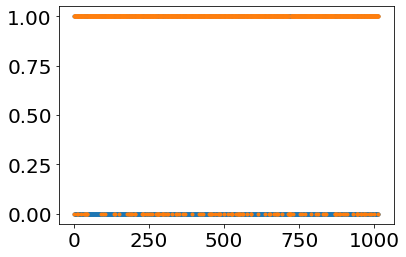

In [26]:
plt.plot(Q,'.')

In [30]:
label=np.argmax(Q,axis=1)
(label==1).sum()

894

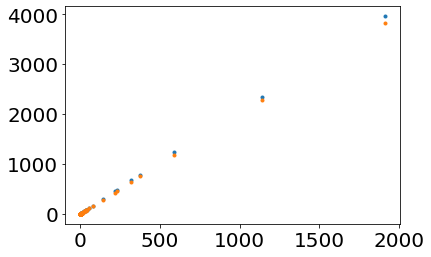

In [28]:
plt.plot(PM.theta[0,:,0],PM.theta[1,:,0],'.')
plt.plot(PM.theta[0,:,0],2*PM.theta[0,:,0],'.')

In [38]:
XX = data[(label==1)]

gene_mask = (np.mean(XX,axis=0)>0) & (np.var(XX,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.06308284067958143


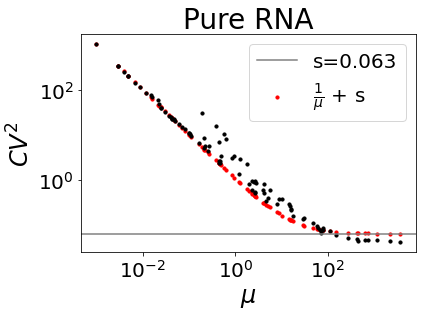

In [41]:
matplotlib.rc('font', size=20)
eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='gray',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=10)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("Pure RNA",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Pgenes

23898


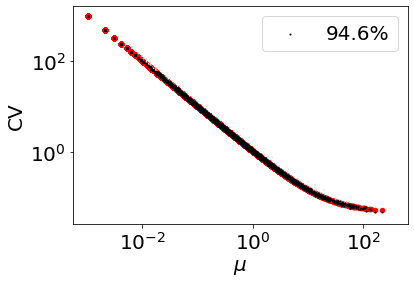

In [96]:
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + s*X_bar**2)-1) < 0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

In [98]:
old_Pgenes_s = s
print('old Pgenes_s =', old_Pgenes_s)
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + old_Pgenes_s*X_bar**2)-1)<0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

x=X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)
x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
new_Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('new Pgenes_s =',new_Pgenes_s)

old Pgenes_s = 0.048379452311131985
23898
new Pgenes_s = 0.048044352846043685


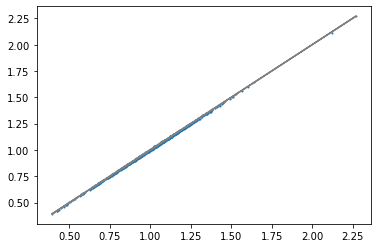

In [11]:
x=X[:,Pgene_mask]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(data.sum(axis=1)/data.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),s=1);
ax.plot(x.sum(axis=1)/x.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),c='grey');

## Bootstrap

In [12]:
s_bootstrap = bootstrap_s(X,B=100,cores=10)

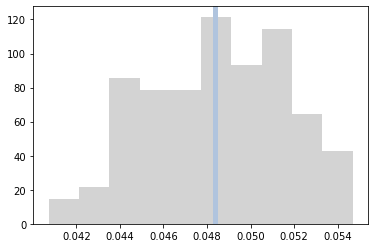

In [13]:
plt.hist(s_bootstrap,color='lightgray',bins=10,density=True)
plt.axvline(x=s,color='lightsteelblue',linewidth=5)

# RNA mixture CEL-seq

In [107]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3305nnn/GSM3305230/suppl/GSM3305230_CelSeq2_Mixture_Sample_counts.csv.gz

--2023-03-20 21:00:27--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3305nnn/GSM3305230/suppl/GSM3305230_CelSeq2_Mixture_Sample_counts.csv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.7, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2595685 (2.5M) [application/x-gzip]
Saving to: ‘GSM3305230_CelSeq2_Mixture_Sample_counts.csv.gz’

GSM3305230_CelSeq2_ 100%[===================>]   2.47M  2.59MB/s    in 1.0s    

2023-03-20 21:00:30 (2.59 MB/s) - ‘GSM3305230_CelSeq2_Mixture_Sample_counts.csv.gz’ saved [2595685/2595685]



In [109]:
!gunzip GSM3305230_CelSeq2_Mixture_Sample_counts.csv.gz

In [159]:
Data = pd.read_csv('data/GSM3305230_CelSeq2_Mixture_Sample_counts.csv',)
Data.T

,0,1,2,3,4,5,6,7,8,9,...,27264,27265,27266,27267,27268,27269,27270,27271,27272,27273
gene_id,ENSG00000269779,ENSG00000250384,ENSG00000272787,ENSG00000163736,ENSG00000276645,ENSG00000235368,ENSG00000260423,ENSG00000080854,ENSG00000235266,ENSG00000100385,...,ENSG00000099958,ENSG00000270987,ENSG00000251463,ENSG00000266709,ENSG00000237836,ENSG00000157014,ENSG00000231404,ENSG00000224934,ENSG00000189157,ENSG00000240498
CelSeq2_Mixture_Sample_A1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
CelSeq2_Mixture_Sample_A2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CelSeq2_Mixture_Sample_A3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CelSeq2_Mixture_Sample_A4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CelSeq2_Mixture_Sample_P20,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,2,0,0,0,0
CelSeq2_Mixture_Sample_P21,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
CelSeq2_Mixture_Sample_P22,1,1,1,1,1,1,1,0,0,0,...,1,0,0,0,0,2,0,0,0,0
CelSeq2_Mixture_Sample_P23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
data = np.array(Data.to_numpy().T[1:,],dtype=float)
var_names = np.array(Data.to_numpy().T[0,],dtype=str)
data.shape

(383, 27274)

In [161]:
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.5798248245606605


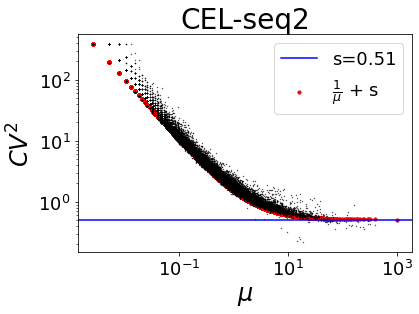

In [162]:
s = 0.51

matplotlib.rc('font', size=18)
eta_0 = -1
Ec = 0.04
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=0.1)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("CEL-seq2",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

In [163]:
data.sum(1).max()

113981.0

In [164]:
import matplotlib.pyplot as plt
from math import factorial, exp, log
from scipy import integrate, special
from tqdm import tqdm

def f_func(x,z):
    I=len(z)
    J=len(x)
    z=np.reshape(z,(I,1))
    x=np.reshape(x,(1,J))
    Z=np.repeat(z,J,axis=1)
    X=np.repeat(x,I,axis=0)    
    return np.exp(np.log(Z+10**(-10))*X-z-special.gammaln(x+1))

x = data.sum(1)

# parameters
ite_num=10
z_range=120000  

# initialization
n=len(x)
dz=1
z=np.arange(0,z_range+dz,dz) # here use z to denote the discretized t
pi=np.ones_like(z)/z_range
z=np.reshape(z,(len(z),1))


unique, counts = np.unique(x, return_counts=True)
f=f_func(unique,z)
L=np.zeros([ite_num,len(unique)])

# iteration
for i in tqdm(range(ite_num)):  
    f_int=integrate.trapz(f*pi[:,None],z,axis=0) 
    pi=pi*np.sum(counts[None,:]*f/f_int,axis=1)/n
    L[i,:]=f_int

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Text(0.5, 1.0, '     total counts distribution')

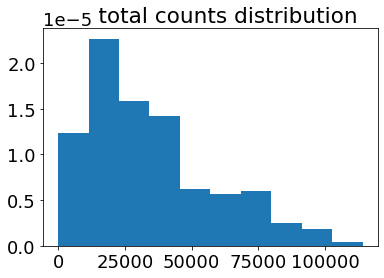

In [172]:
plt.hist(data.sum(1),density=True);
plt.title('     total counts distribution')

Text(0.5, 1.0, 'read depth distribution')

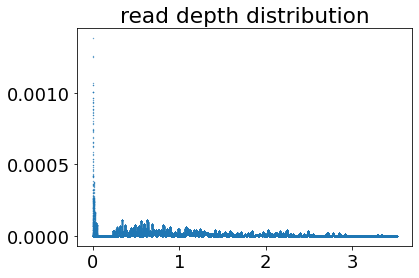

In [173]:
plt.scatter(z/x.mean(),pi,s=0.1);
plt.title('read depth distribution')

In [166]:
m1 = (z[:,0]*pi).sum()
m2 = ((z[:,0]-m1)**2*pi).sum()
m3 = ((z[:,0]-m1)**3*pi).sum()
m4 = ((z[:,0]-m1)**4*pi).sum()
m5 = ((z[:,0]-m1)**5*pi).sum()
m6 = ((z[:,0]-m1)**6*pi).sum()
m2/m1**2

0.5136577009404378